In [2]:
import numpy as np
import fireworks
from fireworks import ic, nbodylib
from fireworks.ic import *
from fireworks.nbodylib import *
from fireworks.nbodylib.integrators import *
from fireworks.nbodylib.dynamics import *
from fireworks.nbodylib.potentials import *
from fireworks.nbodylib.timesteps import *
import matplotlib.pyplot as plt


## A. Generate IC:

Implemented ic functions and tested them in ic.py and test_ic.py

## B. Basic direct force implementation:

Implemented acceleration_direct function in dynamics

## C. Vectorised direct force implementation:

Implemented acceleration_direct_vecotrized function in dynamics

## D. Testing

Implemented tests in test_accelleration_estimate.py

## E. Comparison and benchmark:

E. Comparison and benchmark: You are now ready to test the
performance of your direct force estimate implementations and
compare them with the fast-multipole tree-based gravity solver
developed by Dehnen2002 (https://arxiv.org/pdf/astro-ph/
0202512.pdf). This method is implemented in the function
nbodylib.dynamics.acceleration_pyfalcon. To solve this task you have
to evaluate the computational time required to estimate the particle
accelerations considering the different implemented functions and
different values for the particles number N. So:
1. Select a grid of values for the number of particles to test.
2. For each N, generate random initial conditions using the function
you added in fireworks in task A.
3. Then, estimate the particles acceleration using the three
i m p l e m e n t e d m e t h o d i n t h e s u b m o d u l e
fi r e w o r k s . n b o d y l i b . d y n a m i c s : a c c e l e r a t i o n _ d i r e c t ,
acceleration_direct_ vectorised, acceleration_pyfalcon. For each of
the functions, evaluate the time required to complete the
acceleration estimate. For this purpose you can use the built-in
time package, e.g.:
import time
t1=time.perf_counter()
#operation
t2=time.perf_counter()
dt=t2-t1 # time elapsed from t1 to t2 in
s
4. Collect all the (Nparticles,time) pairs and make a plot Nparticles vs
time plot using three different curves for the three different
methods.
5. Comment the results you obtain. Are the results in line with the
theoretical expectations? Comments on what you think is the
realistic maximum number of particles that can be simulated using
the three different functions.

In [4]:
import time

part = []
N = [50,100,200,300,500, 1000]
min_max_pos=[1, 100]
min_max_vel=[1, 100]
min_max_mass=[1, 10]

time_ad = []
time_adv = []
time_apf = []

for i, n in enumerate(N):

    part.append(ic_random_uniform(n,min_max_pos,min_max_vel,min_max_mass)) 

    t1=time.perf_counter()
    acc_d, jerk_d, _ = acceleration_direct(part[i])
    t2=time.perf_counter()
    dt_d=t2-t1

    t1=time.perf_counter()
    acc_dv, jerk_dv, _ = acceleration_direct_vectorised(part[i])
    t2=time.perf_counter()
    dt_dv=t2-t1

    t1=time.perf_counter()
    acc_pf, jerk_pf, pot_pf = acceleration_pyfalcon(part[i], softening = 1e-6)
    t2=time.perf_counter()
    dt_pf=t2-t1

    time_ad.append(dt_d)
    time_adv.append(dt_dv)
    time_apf.append(dt_pf)

# Plot

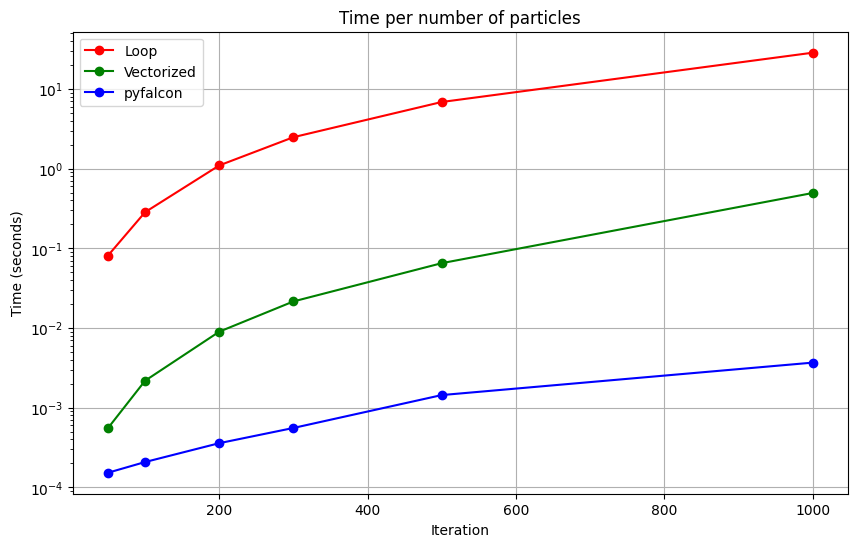

In [5]:
# Example values and time data
values = [50,100,200,300,500, 1000]

# Increase the figure size
plt.figure(figsize=(10, 6))

# Plotting the time for each iteration with legends
plt.plot(values, time_ad, marker='o', linestyle='-', color='r', label='Loop')
plt.plot(values, time_adv, marker='o', linestyle='-', color='g', label='Vectorized')
plt.plot(values, time_apf, marker='o', linestyle='-', color='b', label='pyfalcon')

# Set the y-axis to log scale
plt.yscale('log')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.title('Time per number of particles')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Show the plot
plt.show()

## Comments

In N-body simulations of stellar dynamics, the computation, at every time step, of the gravitational forces between $N$ mutually interacting bodies dominates the operational effort. Instead of computing the forces exactly by direct summation over all pairs of bodies, one may use approximate but much faster methods, allowing substantially larger $N$ and reduced noise, by exploiting the mutual symmetry of the interactions.

Our results are in line with the theoretical expectations. As can be seen from the plot above, the **loop** implementation is the slowest, especially as the number of particles increases. Its time complexity is $O(N^2)$, with $N$ being the number of particles, making it less scalable for large numbers. This happens because it involves nested loops to calculate pairwise interactions.

The **vectorized** implementation is faster and more efficient than the loop implementation, as it leverages NumPy's array operations. The time complexity is expected to be better but still depends on the efficiency of NumPy operations. The difference of the time involved in our case, with an increasing $N$, is of almost two orders of magnitude.

The **pyfalcon** implementation <sup><a href="#ref1">[1]</a></sup> is designed for application in the low-accuracy regime, that combines the tree code and the fast multipole method (FMM), whereby taking the better of each. \
The first method consists in firstly sorting the bodies into a hierarchical tree of cubic cells and pre-computes multipole moments of each cell. Next, the force at any body’s position and generated by the contents of some cell is calculated by a multipole expansion if the cell is well-separated from the body; otherwise the forces generated by the cell’s child nodes are taken. This technique reduces the number of interactions per body to $O(\log(N))$ and hence results in an overall complexity of $O(N\log(N))$. \
The FMM method works similarly by computing the forces between grid cells by a multipole expansion, usually in spherical harmonics. The complexity is formally reduced to $O(N)$. \
In order to be fully adaptive, the **pyfalcon** method uses a hierarchical tree of cubic cells. Whether a given cell-cell interaction can be executed or must be split, is decided using an improved multipole-acceptance criterion (MAC). It is substantially faster than the tree code and empirically shows a complexity of $O(N)$ or even less. \
In our case, the implementation is vastly outperforming both the loop and vectorized ones, achieving a two-order speedup over the vectorized version and a four-order improvement compared to the loop version, thanks to the use of C and memory allocation.

The realistic **maximum number** of particles that can be simulated will depend on various factors such as the computational resources available, algorithm efficiency, and desired simulation time.

According to the tests<sup><a href="#ref1">[2]</a></sup> run by pyfalcon's developers, for large N (in typical astrophysical problem, $N = 10^5$) the computational costs are found to scale almost linearly with N. The scaling of the CPU time required for the mutual forces of a number N of bodies becomes essentially linear at $N \ge 10^5$, allowing for a substantial improvement in simulations employing large number of bodies. The only disadvantage is the increased requirement of memory, with the code requiring a constant amount of CPU time per body. 

Regarding the loop implementation, we could expect the maximum number to be of the order of $10^3$, depending on the computational resources available. Beyond this range, the computation time may increase significantly and become impractical, given the nested structure. The vectorized implementation can handle a larger number of particles, potentially reaching tens of thousands of particles. A realistic maximum number could be in the range of $10^5$ to $5 \dot 10^5$ particles.

The actual limits can be determined through experimentation and profiling on the specific hardware and software environment. In order to find the critical limits to performance, it might be considered exploring parallel computing techniques or GPU acceleration. 

<a id="ref1">[1]</a> https://arxiv.org/pdf/astro-ph/0202512.pdf \
<a id="ref1">[2]</a> https://iopscience.iop.org/article/10.1086/312724/pdf


## F. (Optional) Jerk estimate:

Implemented Jerk in acceleration_direct and acceleration_direct_vectorized